### Importing all the required libraries

In [1]:
import cv2
import csv
import os
import string
import requests
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
from IPython.display import clear_output as cls
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.utils import plot_model

### Counting PNG Images in the Training Dataset Directory

In [2]:
a=0
for filename in os.listdir("training_data_gan"):
  if filename.endswith('.png'):
    a+=1

print(a)

9225


### Generating CSV Metadata File for Word Image Dataset
This function creates a CSV file containing filenames and their corresponding word labels (derived from the filename) for all images in the 'training_data_gan' folder, excluding files named exactly .png. This CSV acts as metadata for training the GAN.

In [3]:
def create_csv_from_folder(folder_path, csv_file_path):
    # Getting a list of all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Creating or overwriting the CSV file
    with open(csv_file_path, 'w', newline='') as csv_file:
        # Create a CSV writer object
        csv_writer = csv.writer(csv_file)

        # Writing the header row
        csv_writer.writerow(['FILENAME', 'IDENTITY'])

        # Writing data rows, excluding files with the name ".png"
        for file_name in files:
            if file_name.lower() == ".png":
                continue  # Skipping files with the name ".png"

            # file_path = os.path.join(folder_path, file_name)

            # Removing the file extension (assuming it's three characters long, like '.png')
            file_name_without_extension = os.path.splitext(file_name)[0]

            csv_writer.writerow([file_name, file_name_without_extension])

    print(f'CSV file "{csv_file_path}" created successfully.')

# Training data
training_data = "training_data_gan"
train_csv_path = './training_data.csv'
create_csv_from_folder(training_data, train_csv_path)

CSV file "./training_data.csv" created successfully.


In [4]:
df = pd.read_csv('training_data.csv')
df.shape

(9225, 2)

### Extracting the first meaningful word from each entry using two split() operations

In [5]:
df['IDENTITY'] = df['IDENTITY'].apply(lambda x: x.split('_')[0]).apply(lambda x: x.split(' ')[0])

In [6]:
df.to_csv('train.csv', index=False)
df.head()

,FILENAME,IDENTITY
0,& (1).png,&
1,& (1)_rot-1.png,&
2,& (1)_rot-2.png,&
3,& (1)_rot1.png,&
4,& (1)_rot2.png,&


### Defining File Paths for Training Data and Metadata CSV

In [7]:
# File Paths
train_csv_path = './train.csv'
train_image_dir = 'training_data_gan'

###  Loading Training Metadata CSV into a DataFrame

In [8]:
# Train CSV
train_csv = pd.read_csv(train_csv_path)

Extracting Word Labels from the DataFrame

In [9]:
labels = [str(word) for word in df['IDENTITY'].to_numpy()]
labels[:10]

['&', '&', '&', '&', '&', '&', '&', '&', '&', '&']

### Identifying Unique Characters in the Dataset

In [10]:
# Unique characters
unique_chars = set(char for word in labels for char in word)
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 43
Unique Characters : 
{'y', 'P', 'H', 'a', 'b', 'N', ',', 'g', 'T', 'l', 'V', 'C', 'd', 'p', 'r', 'z', 'G', 'j', 'q', 'R', 'Y', 'n', 'u', 'i', 'S', 'm', 'o', 'A', 'h', 'c', 't', 's', 'F', 'x', '-', 'M', '&', 'J', 'e', 'Q', 'B', 'E', 'O'}


### Appending Directory Path to Image Filenames in Metadata

In [11]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]

In [12]:
train_csv.head()

,FILENAME,IDENTITY
0,training_data_gan/& (1).png,&
1,training_data_gan/& (1)_rot-1.png,&
2,training_data_gan/& (1)_rot-2.png,&
3,training_data_gan/& (1)_rot1.png,&
4,training_data_gan/& (1)_rot2.png,&


### Custom Keras Dataset Class for Loading and Preprocessing Word Images

In [13]:
# Continuing building the dataset class and model setup

class CharacterDatasetFromCSV(tf.keras.utils.Sequence):
    def __init__(self, df, img_size=200, batch_size=32):
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.classes = sorted(df["IDENTITY"].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}
        self.image_label_pairs = list(zip(df["FILENAME"], df["IDENTITY"]))
        np.random.shuffle(self.image_label_pairs)

    def __len__(self):
        return (len(self.image_label_pairs) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        batch_data = self.image_label_pairs[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, labels = [], []
        for path, label in batch_data:
            img = Image.open(path).convert("L").resize((self.img_size, self.img_size))
            img = np.array(img) / 127.5 - 1.0
            images.append(img)
            labels.append(self.class_to_idx[label])
        images = np.expand_dims(np.array(images), axis=-1)
        labels = np.array(labels)
        return images, labels

### Initializing Dataset and Computing Number of Unique Word Classes

In [14]:
dataset = CharacterDatasetFromCSV(train_csv, img_size=200, batch_size=32)
num_classes = len(dataset.class_to_idx)
print(num_classes)

43


### Building the Conditional GAN Generator Model

In [15]:
from tensorflow.keras.models import Model

z_dim = 100

# Building the Generator

def build_generator(z_dim=100, img_size=200, num_classes=num_classes):
    noise_input = layers.Input(shape=(z_dim,))
    label_input = layers.Input(shape=(1,), dtype=tf.int32)
    label_embedding = layers.Embedding(num_classes, z_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    x = layers.Concatenate()([noise_input, label_embedding])
    x = layers.Dense(25 * 25 * 256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((25, 25, 256))(x)
    x = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(1, kernel_size=5, strides=1, padding="same", activation="tanh")(x)
    return Model([noise_input, label_input], x)

### Defining the Conditional GAN Discriminator, Loss Functions, and Training Step

In [16]:
# Building the Discriminator

def build_discriminator(img_size=200, num_classes=num_classes):
    img_input = layers.Input(shape=(img_size, img_size, 1))
    label_input = layers.Input(shape=(1,), dtype=tf.int32)
    label_embedding = layers.Embedding(num_classes, img_size * img_size)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((img_size, img_size, 1))(label_embedding)
    x = layers.Concatenate()([img_input, label_embedding])
    x = layers.Conv2D(64, 5, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, 5, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)
    return Model([img_input, label_input], x)

generator = build_generator(z_dim=z_dim, img_size=200, num_classes=num_classes)
discriminator = build_discriminator(img_size=200, num_classes=num_classes)

cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def train_step(images, labels):
    if images.shape[0] == 0:
        return tf.constant(0.0), tf.constant(0.0)

    # Converting both to tensors
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    labels = tf.reshape(labels, (-1, 1))

    noise = tf.random.normal([tf.shape(images)[0], z_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return g_loss, d_loss

### Displaying Class-to-Index Mapping for Word Labels

In [17]:
for char, idx in dataset.class_to_idx.items():
    print(f"Character: {char} --> Index: {idx}")

Character: & --> Index: 0
Character: , --> Index: 1
Character: - --> Index: 2
Character: A --> Index: 3
Character: B --> Index: 4
Character: C --> Index: 5
Character: E --> Index: 6
Character: F --> Index: 7
Character: G --> Index: 8
Character: H --> Index: 9
Character: J --> Index: 10
Character: M --> Index: 11
Character: N --> Index: 12
Character: O --> Index: 13
Character: P --> Index: 14
Character: Q --> Index: 15
Character: R --> Index: 16
Character: S --> Index: 17
Character: T --> Index: 18
Character: V --> Index: 19
Character: Y --> Index: 20
Character: a --> Index: 21
Character: b --> Index: 22
Character: c --> Index: 23
Character: d --> Index: 24
Character: e --> Index: 25
Character: g --> Index: 26
Character: h --> Index: 27
Character: i --> Index: 28
Character: j --> Index: 29
Character: l --> Index: 30
Character: m --> Index: 31
Character: n --> Index: 32
Character: o --> Index: 33
Character: p --> Index: 34
Character: q --> Index: 35
Character: r --> Index: 36
Character: 

### Visualizing Sample Generated Character Images for Given Label Indices

In [18]:
# import matplotlib.pyplot as plt

# def show_generated_images_for_labels(generator, label_indices, z_dim=100):
#     if len(label_indices) != 3:
#         raise ValueError("Please provide exactly 3 label indices")

#     noise = tf.random.normal([3, z_dim])
#     labels = tf.constant(label_indices, dtype=tf.int32)
#     labels = tf.reshape(labels, (-1, 1))
#     generated_images = generator([noise, labels], training=False)
#     generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]

#     fig, axs = plt.subplots(1, 3, figsize=(6, 2))
#     for i in range(3):
#         axs[i].imshow(generated_images[i, :, :, 0], cmap='binary_r')
#         axs[i].set_title(f"Label {label_indices[i]}")
#         axs[i].axis('off')
#     plt.tight_layout()
#     plt.show()

### Training the Conditional GAN and Saving Generator Models Across Epochs

In [19]:
# from tqdm import trange
# import time
# import tensorflow as tf
# import os
# import matplotlib.pyplot as plt

# # Directory to save models
# save_dir = "saved_generators"
# os.makedirs(save_dir, exist_ok=True)

# # Loss tracking
# g_losses = []
# d_losses = []

# epochs = 100

# for epoch in range(epochs):
#     print(f"\nEpoch {epoch + 1}/{epochs}")
#     start_time = time.time()

#     total_batches = len(dataset)
#     for batch_idx in trange(total_batches, desc="Training", ncols=100):
#         images, labels = dataset[batch_idx]
#         g_loss, d_loss = train_step(images, labels)

#     print(f"Epoch {epoch + 1} completed in {time.time() - start_time:.2f}s")
#     print(f"  Final Batch Losses -> G: {g_loss:.4f} | D: {d_loss:.4f}")

#     # Track losses
#     g_losses.append(g_loss)
#     d_losses.append(d_loss)

#     # Save generator with epoch number (no overwrite)
#     epoch_save_path = os.path.join(save_dir, f"generator_epoch_{epoch + 1:03d}.h5")
#     generator.save(epoch_save_path)
#     print(f" Generator saved: {epoch_save_path}")

#     # Display samples
#     label_indices = [0, 19, 37]  # Replace with any 3 labels you'd like to visualize
#     show_generated_images_for_labels(generator, label_indices)

# # === Plotting Loss Curves After Training ===
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(g_losses) + 1), g_losses, label='Generator Loss')
# plt.plot(range(1, len(d_losses) + 1), d_losses, label='Discriminator Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Generator and Discriminator Loss Over Epochs')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


### Loading a Pretrained Generator Model from Checkpoint

Please download the **pretrained model** from the link provided below.  
**Download Link:** [Pretrained Model](https://drive.google.com/file/d/1sMYQyWfhLTpR_jcd4sD2UZP5fvXdSQzK/view?usp=sharing)  

Make sure to place the downloaded model file in the current directory before proceeding with the next steps.

In [20]:
from tensorflow.keras.models import load_model

# Loading the best saved generator model
generator = load_model("generator_epoch_061.h5")

In [21]:
import zipfile

with zipfile.ZipFile("Transcripts.zip", 'r') as zip_ref:
    zip_ref.extractall(".")  # "." indicates the current directory

### Extracting and Formatting Word-Level Transcripts from .docx Files

This script processes .docx documents containing text segmented by headings like "PDF p1", "PDF p2", etc., and converts the content into clean word-level transcripts.

In [22]:
import re
import os
from docx import Document

# Path to the specific .docx file
docx_folder = "Transcripts"
file_name = "Mendo transcription.docx"
docx_path = os.path.join(docx_folder, file_name)

# Output folder for transcripts
transcripts_folder = "Transcript to txt"
os.makedirs(transcripts_folder, exist_ok=True)

# Load the document
doc = Document(docx_path)

# Extracting base name of the document (without extension)
docx_name = os.path.splitext(file_name)[0]

# Initializing variables
page_content = {}
current_page = None

# Reading document and segregate by "PDF pX" headings
for para in doc.paragraphs:
    text = para.text.strip()

    # Detect headers like "PDF p1", "PDF p2", etc.
    if re.match(r"^PDF p\d+", text):
        current_page = text  # Example: "PDF p1"
        page_content[current_page] = []
    elif current_page:  # Store content under the detected page header
        page_content[current_page].append(text)

# Processing each page and save to corresponding .txt file
for page, content in page_content.items():
    # Extracting the page number from "PDF pX"
    page_number = re.search(r"\d+", page).group()

    # Generating output file name
    output_file = os.path.join(transcripts_folder, f"{docx_name}_page_{page_number}_transcript.txt")

    # Flattening content into a single string
    full_text = " ".join(content)

    # Splitting into words (treating punctuation as separate words)
    words = re.findall(r"[\w]+|[^\w\s]", full_text)

    # Saving to file (one word per line)
    with open(output_file, "w", encoding="utf-8") as f:
        previous_word = None  # To store the last word

        for word in words:
            if word == "-":
                if previous_word is not None:
                    previous_word += "-"
            elif word == ",":
                if previous_word is not None:
                    previous_word += ","
            else:
                if previous_word is not None:
                    f.write(previous_word + "\n")  # Writing the previous word
                previous_word = word  # Updating previous word

        # Writing the last word if it exists
        if previous_word is not None:
            f.write(previous_word + "\n")

    print(f"Saved: {output_file}")

print("Processing complete! Transcripts saved in the 'Transcript to txt' folder.")


Saved: Transcript to txt\Mendo transcription_page_1_transcript.txt
Saved: Transcript to txt\Mendo transcription_page_2_transcript.txt
Saved: Transcript to txt\Mendo transcription_page_3_transcript.txt
Saved: Transcript to txt\Mendo transcription_page_4_transcript.txt
Saved: Transcript to txt\Mendo transcription_page_5_transcript.txt
Processing complete! Transcripts saved in the 'Transcript to txt' folder.


### Generating and Saving Aligned Synthetic Word Images from Text Files Using a Trained Generator
This script enables word-level image generation using a trained Conditional GAN generator, with proper typographic alignment and batch processing from .txt files

### Key Components:

- **Character Grouping:**  
  Categorizes characters into ascenders, descenders, x-height letters, and punctuation to ensure accurate vertical alignment.

- **`trim_whitespace()`:**  
  Removes blank margins from generated characters to eliminate unnecessary padding.

- **`resize_and_baseline_align()`:**  
  Resizes and vertically aligns each character based on its typographic role:  
  - Punctuation like commas sits lower,  
  - Ascenders reach the top,  
  - Descenders dip below the baseline.

- **`generate_and_save_word_image()`:**  
  - Converts a word into valid character labels.  
  - Generates images for each character.  
  - Applies smoothing, alignment, and spacing.  
  - Concatenates characters into a word image.  
  - Saves the final image as a PNG in the specified output folder.

- **`generate_from_all_txt()`:**  
  - Iterates through all `.txt` files in a given folder.  
  - Reads word lists from each file.  
  - Generates and saves word images using the generator model.  
  - Organizes outputs into subfolders named after each input file.

In [23]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter, zoom
from PIL import Image

# Character groups
descenders = {'g', 'j', 'p', 'q', 'y'}
ascenders = {'b', 'd', 'h', 'l', 't'}
xheight_letters = set('abcdeghijlmnopqrstuvxyz') - descenders - ascenders
punctuation = {',', '-'}

def trim_whitespace(image, threshold=0.9):
    mask = image < threshold
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    return image[np.ix_(rows, cols)]

def resize_and_baseline_align(img, char, full_height, reference_height=None,
                               xheight=0.6, descender_frac=0.25, punctuation_scale=0.4):
    """
    Resize and baseline-align character images according to typographic role.
    Handling proper vertical alignment for punctuation based on previous character.
    """
    if char == ',':
        target_height = int(full_height * punctuation_scale)
        resized = zoom(img, (target_height / img.shape[0], target_height / img.shape[0]), order=1)
        pad_top = full_height - target_height
        pad_bottom = 0
        total_height = full_height

    elif char == '-' and reference_height:
        target_height = int(full_height * punctuation_scale)
        resized = zoom(img, (target_height / img.shape[0], target_height / img.shape[0]), order=1)

        # Centering the hyphen vertically w.r.t. the previous character image height
        midline = reference_height // 2
        pad_top = midline - target_height // 2
        pad_bottom = full_height - target_height - pad_top
        total_height = full_height

    elif char.isupper() or char in ascenders:
        target_height = full_height
        resized = zoom(img, (target_height / img.shape[0], target_height / img.shape[0]), order=1)
        pad_top = 0
        pad_bottom = 0
        total_height = full_height

    elif char in xheight_letters:
        target_height = int(full_height * xheight)
        resized = zoom(img, (target_height / img.shape[0], target_height / img.shape[0]), order=1)
        pad_top = full_height - target_height
        pad_bottom = 0
        total_height = full_height

    elif char in descenders:
        x_part = int(full_height * xheight)
        d_part = int(full_height * descender_frac)
        target_height = x_part + d_part
        resized = zoom(img, (target_height / img.shape[0], target_height / img.shape[0]), order=1)
        pad_top = full_height - x_part
        pad_bottom = 0
        total_height = full_height + d_part

    else:
        resized = zoom(img, (full_height / img.shape[0], full_height / img.shape[0]), order=1)
        pad_top = 0
        pad_bottom = 0
        total_height = full_height

    padded = np.pad(resized, ((pad_top, pad_bottom), (0, 0)), mode='constant', constant_values=1.0)
    return padded, padded.shape[0]  # return actual rendered height

def generate_and_save_word_image(generator, word, class_to_idx, save_path, z_dim=100):
    word_for_generation = word.replace('v', 'u')
    valid_chars = [c for c in word_for_generation if c in class_to_idx]

    if not valid_chars:
        print(f"Skipping '{word}' – no valid characters.")
        return

    label_indices = [class_to_idx[c] for c in valid_chars]
    noise = tf.random.normal([len(label_indices), z_dim])
    labels = tf.constant(label_indices, dtype=tf.int32)
    labels = tf.reshape(labels, (-1, 1))

    generated_images = generator([noise, labels], training=False)
    generated_images = (generated_images + 1) / 2.0
    images_np = generated_images.numpy()
    images_np = np.squeeze(images_np, axis=-1)

    trimmed_images = [trim_whitespace(gaussian_filter(img, sigma=0.5)) for img in images_np]
    full_height = max(img.shape[0] for img in trimmed_images)

    aligned_images = []
    for i, char in enumerate(valid_chars):
        # Getting actual height of previous rendered image (if needed)
        ref_height = aligned_images[-1].shape[0] if char == '-' and i > 0 else None
        aligned, _ = resize_and_baseline_align(trimmed_images[i], char, full_height, reference_height=ref_height)
        aligned_images.append(aligned)

    # Matching height across all characters
    max_total_height = max(img.shape[0] for img in aligned_images)
    final_images = [
        np.pad(img, ((0, max_total_height - img.shape[0]), (0, 0)), mode='constant', constant_values=1.0)
        for img in aligned_images
    ]

    # Adding spacing except before punctuation
    spaced_images = []
    for i, img in enumerate(final_images):
        spaced_images.append(img)
        if i < len(final_images) - 1 and valid_chars[i + 1] not in punctuation:
            spacing = np.ones((max_total_height, 3))  # small gap
            spaced_images.append(spacing)

    word_image = np.concatenate(spaced_images, axis=1)
    img_uint8 = (word_image * 255).astype(np.uint8)
    img_pil = Image.fromarray(img_uint8)
    img_pil.save(os.path.join(save_path, f"{word}.png"))

def generate_from_all_txt(generator, input_folder, class_to_idx, z_dim=100, root_output_dir="gan_generated_words"):
    os.makedirs(root_output_dir, exist_ok=True)

    # Looping through all .txt files in the folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".txt"):
            txt_path = os.path.join(input_folder, filename)
            base_name = os.path.splitext(filename)[0]
            output_dir = os.path.join(root_output_dir, f"words_dataset_{base_name}")
            os.makedirs(output_dir, exist_ok=True)

            with open(txt_path, 'r') as f:
                words = [line.strip() for line in f if line.strip()]

            for word in words:
                generate_and_save_word_image(generator, word, class_to_idx, output_dir, z_dim=z_dim)



In [24]:
generate_from_all_txt(generator, input_folder="Transcript to txt", class_to_idx=dataset.class_to_idx, z_dim=100)

Skipping '.' – no valid characters.
Skipping '.' – no valid characters.
Skipping '(' – no valid characters.
Skipping ')' – no valid characters.
Skipping '.' – no valid characters.
Skipping '.' – no valid characters.
Skipping '.' – no valid characters.
Skipping '.' – no valid characters.
Skipping 'I' – no valid characters.
Skipping '.' – no valid characters.
Skipping '.' – no valid characters.
Skipping '.' – no valid characters.
Skipping '.' – no valid characters.
Skipping 'I' – no valid characters.
Skipping '.' – no valid characters.
Skipping ';' – no valid characters.
Skipping ':' – no valid characters.
Skipping ':' – no valid characters.
Skipping '.' – no valid characters.
Skipping ':' – no valid characters.
Skipping ':' – no valid characters.
Skipping ':' – no valid characters.
Skipping '.' – no valid characters.
Skipping '.' – no valid characters.
Skipping 'I' – no valid characters.
Skipping '.' – no valid characters.
Skipping '.' – no valid characters.
Skipping '.' – no valid char

### Converting PDF Pages to Images Using PyMuPDF (fitz)

This script converts the first 5 pages of a given PDF into PNG images using the PyMuPDF (fitz) library and saves them in a structured folder format.

In [25]:
import os
import fitz  # PyMuPDF

# Define the name of the PDF file in the current directory
file_name = "Mendo - Principe perfecto.pdf"  # Replace this with your desired PDF file name
pdf_path = os.path.abspath(file_name)

# Define the output base folder
output_base_folder = "pdf_to_images"
os.makedirs(output_base_folder, exist_ok=True)

def pdf_to_images(pdf_path, output_folder):
    pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
    pdf_output_folder = os.path.join(output_folder, pdf_name)
    os.makedirs(pdf_output_folder, exist_ok=True)

    doc = fitz.open(pdf_path)

    for i, page in enumerate(doc, start=1):
        if i <= 5:  # Saving only the first 3 pages
            pix = page.get_pixmap()
            image_path = os.path.join(pdf_output_folder, f"{pdf_name}_page_{i}.png")
            pix.save(image_path)

    print(f"Images saved in folder: {pdf_output_folder}")

# Process the PDF file
pdf_to_images(pdf_path, output_base_folder)

Images saved in folder: pdf_to_images\Mendo - Principe perfecto


#### OCR-Based Word Segmentation and Image Cropping from PDF-Derived Page Images

This script uses Tesseract OCR to detect and crop individual word images from page-level PNG images (extracted from PDFs), saving each word as a separate image file.

In [26]:
import os
import cv2
import pytesseract
import pandas as pd
from PIL import Image

# Folder containing input images
input_folder = "pdf_to_images"
output_base = "ocr_generated_words"
os.makedirs(output_base, exist_ok=True)

# Function to process a single image
def process_image(image_path):
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    output_folder = os.path.join(output_base, f"{base_name}_words")
    os.makedirs(output_folder, exist_ok=True)

    # Load and prepare image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read: {image_path}")
        return
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)

    # OCR with bounding box data
    custom_config = r'--oem 3 --psm 3'
    data = pytesseract.image_to_data(pil_image, config=custom_config, output_type=pytesseract.Output.DICT)

    # Convert to DataFrame
    df = pd.DataFrame({
        "x1": data["left"],
        "y1": data["top"],
        "width": data["width"],
        "height": data["height"],
        "word": data["text"]
    })

    df = df[df["word"].str.strip() != ""]

    # Compute bottom-right coordinates
    df["x2"] = df["x1"] + df["width"]
    df["y2"] = df["y1"] + df["height"]

    # Filter words within horizontal margins
    df["left_margin_metric"] = df["y1"] + df["x1"]
    df["right_margin_metric"] = df["x2"] + df["y2"]
    left_margin = df.loc[df["left_margin_metric"].idxmin()]["x1"]
    right_margin = df.loc[df["right_margin_metric"].idxmax()]["x2"]
    df = df[(df["x2"] >= left_margin) & (df["x1"] <= right_margin)]

    # Save each word as a cropped image
    for idx, row in df.iterrows():
        x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])
        word = row["word"]
        cropped = image[y1:y2, x1:x2]
        
        filename = f"{word}.png"
        save_path = os.path.join(output_folder, filename)

        cv2.imwrite(save_path, cropped)
        print(f"Saved: {save_path}")

    print(f"Completed: {image_path}")

# Walk through all images in the folder
for root, _, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(".png"):
            full_path = os.path.join(root, file)
            process_image(full_path)

print("\n All images processed and saved in 'ocr_generated_images'")


Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\“AL.png
Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\TEEPE.png
Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\SES.png
Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\SEN.png
Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\OR.png
Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\DON.png
Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\ALONSO.png
Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\PEREZ.png
Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\DE.png
Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\GVZMAN.png
Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\EL.png
Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\BVENO,.png
Saved: ocr_generated_words\Mendo - Principe perfecto_page_1_words\PATRIARCHA.png
Saved: ocr_generated_

### Batch-Correcting OCR Word Image Filenames via Transcript Matching with Levenshtein Distance

This script automatically renames and organizes OCR-extracted word images by matching their filenames to words in their corresponding transcript files using fuzzy matching based on Levenshtein distance.

In [28]:
import os
import shutil
import Levenshtein

# Paths
ocr_image_root = "ocr_generated_words"
transcript_root = "Transcript to txt"

# Function to load words from transcript (preserving case)
def load_transcript_words(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return set(f.read().split())

# Function to find best match using Levenshtein distance
def find_best_match(word, transcript_words):
    best_match = None
    best_score = float("inf")

    for tw in transcript_words:
        score = Levenshtein.distance(word.lower(), tw.lower())
        if score < best_score:
            best_score = score
            best_match = tw

    return best_match if best_score <= len(word) * 0.4 else None  # 60% similarity threshold

# Looping over all folders in ocr_generated_images
for folder_name in os.listdir(ocr_image_root):
    input_folder = os.path.join(ocr_image_root, folder_name)

    if not os.path.isdir(input_folder):
        continue  # Skip non-folder entries

    # Attempting to find the correct transcript file
    matching_transcript = None
    for transcript_file in os.listdir(transcript_root):
        if "page_" in folder_name and "page_" in transcript_file:
            page_ref = folder_name.split("page_")[-1].split("_")[0]  # e.g., '1' from 'Buendia_page_1_words'
            if f"page_{page_ref}" in transcript_file:
                matching_transcript = os.path.join(transcript_root, transcript_file)
                break

    if not matching_transcript:
        print(f" No matching transcript found for: {folder_name}")
        continue

    # Loading transcript words
    transcript_words = load_transcript_words(matching_transcript)
    used_filenames = set()

    # Creating output folder
    corrected_folder = os.path.join(ocr_image_root, f"{folder_name}_corrected")
    os.makedirs(corrected_folder, exist_ok=True)

    # Processing each image in the folder
    for image_file in os.listdir(input_folder):
        input_image_path = os.path.join(input_folder, image_file)
        image_name, _ = os.path.splitext(image_file)

        best_match = find_best_match(image_name, transcript_words)

        if best_match:
            if best_match in used_filenames:
                print(f" Skipped duplicate: {image_file} -> {best_match}.png")
                continue

            corrected_path = os.path.join(corrected_folder, f"{best_match}.png")
            shutil.copy(input_image_path, corrected_path)
            used_filenames.add(best_match)
            print(f" Saved: {image_file} -> {corrected_path}")
        else:
            print(f" Skipped: {image_file} (no good match found)")

    print(f" Finished correcting filenames in: {folder_name}\n")

print(" All folders processed and corrected images saved.")


 Skipped: &.png (no good match found)
 Skipped: (bades.png (no good match found)
 Saved: (Illuftriffimo.png -> ocr_generated_words\Mendo - Principe perfecto_page_1_words_corrected\Illustrissimo.png
 Skipped: ,.png (no good match found)
 Saved: ,por.png -> ocr_generated_words\Mendo - Principe perfecto_page_1_words_corrected\por.png
 Skipped: ..png (no good match found)
 Skipped: 2.png (no good match found)
 Skipped: 5.png (no good match found)
 Saved: a.png -> ocr_generated_words\Mendo - Principe perfecto_page_1_words_corrected\a.png
 Saved: aagrades,.png -> ocr_generated_words\Mendo - Principe perfecto_page_1_words_corrected\agrados,.png
 Saved: acciones.png -> ocr_generated_words\Mendo - Principe perfecto_page_1_words_corrected\acciones.png
 Saved: admitira.png -> ocr_generated_words\Mendo - Principe perfecto_page_1_words_corrected\admitira.png
 Saved: aju=.png -> ocr_generated_words\Mendo - Principe perfecto_page_1_words_corrected\aju-.png
 Saved: ALONSO.png -> ocr_generated_words\Me

### Evaluating GAN-Generated Word Images Against OCR Ground Truth Using MSE and SSIM

This script quantitatively and visually evaluates the quality of GAN-generated word images by comparing them with corresponding OCR-cropped originals using Mean Squared Error (MSE) and Structural Similarity Index (SSIM).


 Comparing:
   GAN:  gan_generated_words\words_dataset_Mendo transcription_page_1_transcript
   OCR:  ocr_generated_words\Mendo - Principe perfecto_page_1_words_corrected
 Folder Average - MSE: 0.1330, SSIM: 0.4989

 Comparing:
   GAN:  gan_generated_words\words_dataset_Mendo transcription_page_2_transcript
   OCR:  ocr_generated_words\Mendo - Principe perfecto_page_2_words_corrected
 Skipping 15.png: no GAN counterpart.
 Skipping 1659.png: no GAN counterpart.
 Error loading cariño.png: cannot identify image file 'ocr_generated_words\\Mendo - Principe perfecto_page_2_words_corrected\\cariño.png'
 Folder Average - MSE: 0.1404, SSIM: 0.4971

 Comparing:
   GAN:  gan_generated_words\words_dataset_Mendo transcription_page_3_transcript
   OCR:  ocr_generated_words\Mendo - Principe perfecto_page_3_words_corrected
 Skipping ;.png: no GAN counterpart.
 Folder Average - MSE: 0.1613, SSIM: 0.4485

 Comparing:
   GAN:  gan_generated_words\words_dataset_Mendo transcription_page_4_transcript
   OC

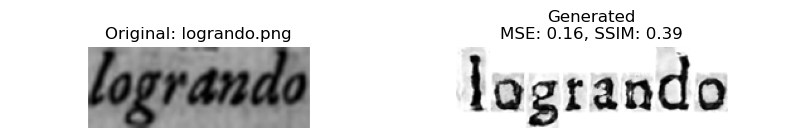

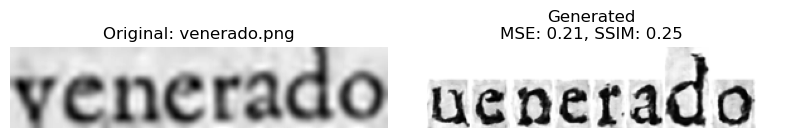

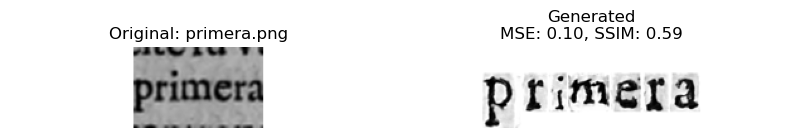

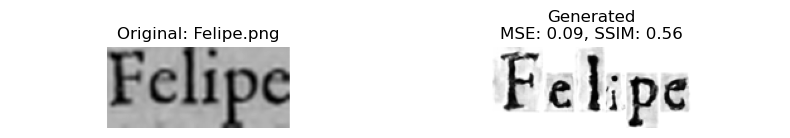

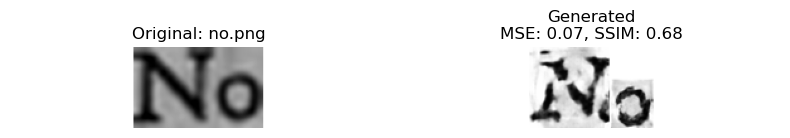

In [30]:
import random

# Root folders
ocr_dir_root = "ocr_generated_words"
gan_dir_root = "gan_generated_words"

# Image preprocessing constants
target_height = 64
max_width = 300

def load_and_preprocess(image_path):
    img = Image.open(image_path).convert('L')
    w, h = img.size
    new_w = int((target_height / h) * w)
    img = img.resize((new_w, target_height), Image.LANCZOS)

    if new_w < max_width:
        pad_left = (max_width - new_w) // 2
        pad_right = max_width - new_w - pad_left
        img = ImageOps.expand(img, (pad_left, 0, pad_right, 0), fill=255)
    else:
        img = img.crop((0, 0, max_width, target_height))

    img_array = np.array(img).astype(np.float32) / 255.0
    return tf.convert_to_tensor(img_array)[..., tf.newaxis]

def compute_metrics(original_img, generated_img):
    mse = tf.reduce_mean(tf.square(original_img - generated_img)).numpy()
    ssim = tf.image.ssim(original_img, generated_img, max_val=1.0).numpy()
    return mse, ssim

def show_example(filename, orig_img, gen_img, mse, ssim):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].imshow(tf.squeeze(orig_img), cmap='gray')
    axs[0].set_title(f"Original: {filename}")
    axs[1].imshow(tf.squeeze(gen_img), cmap='gray')
    axs[1].set_title(f"Generated\nMSE: {mse:.2f}, SSIM: {ssim:.2f}")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Global aggregates
global_mse_total = 0
global_ssim_total = 0
global_count = 0
all_examples = []  # For 5 random examples

# Processing each GAN folder
for gan_folder in os.listdir(gan_dir_root):
    gan_folder_path = os.path.join(gan_dir_root, gan_folder)
    if not os.path.isdir(gan_folder_path):
        continue

    matching_ocr_folder = None
    if "page_" in gan_folder:
        page_ref = gan_folder.split("page_")[-1].split("_")[0]
        for ocr_folder in os.listdir(ocr_dir_root):
            if f"page_{page_ref}" in ocr_folder and "corrected" in ocr_folder:
                matching_ocr_folder = os.path.join(ocr_dir_root, ocr_folder)
                break

    if not matching_ocr_folder:
        print(f" No matching corrected OCR folder found for: {gan_folder}")
        continue

    print(f"\n Comparing:\n   GAN:  {gan_folder_path}\n   OCR:  {matching_ocr_folder}")
    results = []
    local_mse_total = 0
    local_ssim_total = 0
    local_count = 0

    for filename in os.listdir(matching_ocr_folder):
        if not filename.lower().endswith(".png") or 's' in filename.lower():
            continue

        ocr_img_path = os.path.join(matching_ocr_folder, filename)
        gan_img_path = os.path.join(gan_folder_path, filename)

        if not os.path.exists(gan_img_path):
            print(f" Skipping {filename}: no GAN counterpart.")
            continue

        try:
            ocr_img = load_and_preprocess(ocr_img_path)
            gan_img = load_and_preprocess(gan_img_path)
        except Exception as e:
            print(f" Error loading {filename}: {e}")
            continue

        mse, ssim = compute_metrics(ocr_img, gan_img)
        results.append((filename, mse, ssim))

        # Adding for random display
        all_examples.append((filename, ocr_img, gan_img, mse, ssim))

        local_mse_total += mse
        local_ssim_total += ssim
        local_count += 1

        global_mse_total += mse
        global_ssim_total += ssim
        global_count += 1
        
    if local_count > 0:
        avg_mse = local_mse_total / local_count
        avg_ssim = local_ssim_total / local_count
        print(f" Folder Average - MSE: {avg_mse:.4f}, SSIM: {avg_ssim:.4f}")

# Global metrics
if global_count > 0:
    final_avg_mse = global_mse_total / global_count
    final_avg_ssim = global_ssim_total / global_count
    print(f"\n Final Global Average - MSE: {final_avg_mse:.4f}, SSIM: {final_avg_ssim:.4f}")

    # Showing 5 random examples for comparision
    print("\n Displaying 5 random examples across all folders:")
    random.shuffle(all_examples)
    for i in range(min(5, len(all_examples))):
        filename, ocr_img, gan_img, mse, ssim = all_examples[i]
        show_example(filename, ocr_img, gan_img, mse, ssim)
else:
    print("\n No valid image pairs were found for comparison.")
